In [ ]:
# Author: Jaehun Kim
# Email: rlawogns1204@unist.ac.kr
# Affiliation: UNIST BME BCILAB
# Date: 2023-05-15
# For ICROS2023
#
# This code implements a tactile information processing model using a spiking
# neural network (SNN). It simulates the processing of tactile information from
# mechanoreceptors in the skin through primary afferent fibers (PA), cuneate nucleus
# neurons (PN and IN), and ultimately, somatosensory cortex neurons. The model
# incorporates lateral inhibition and various receptive field properties to
# represent a realistic processing of touch stimuli.

# with DIGIT-sensor
# pip install torch==1.8.1+cu101 torchvision==0.9.1+cu101 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io
import time
import numpy as np
from PIL import Image
import io
import datetime

from Function.ReceptiveField import *
from Function.SNNModule import *
from Function.plot_SNN import *
from Function.SNN import *
from Function.Stimulation_GPU import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
# Check if GPU is available and print the CUDA version
print(f"GPU available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Enable GPU support if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the device to 'cpu'
device = 'cpu'

print(f"Using device: {device}")
# Start of the SNN (Spiking Neural Network) code

In [ ]:
# Set sensor dimensions (height and width in millimeters)
sensor_h, sensor_w = 19, 16

# Set pixel dimensions (number of pixels in height and width)
pixel_h, pixel_w = 64, 48

# Set image frames per second (FPS) of tactile sensor
image_FPS = 60

In [ ]:
#1st layer
############################################################################################################################################################
# Generate Slowly Adapting (SA) and Rapidly Adapting (RA) receptive fields
SA_RF, [SA_step_height, SA_step_width] = generate_mechanoreceptor_to_afferent_rf(
    kernel_w=9, kernel_h=11, step_size=5, device=device)
RA_RF, [RA_step_height, RA_step_width] = generate_mechanoreceptor_to_afferent_rf(
    kernel_w=11, kernel_h=14, step_size=4, device=device)

# Print the shape of the SA_rf variable
print("SA_rf shape:", SA_RF.shape, 'with height =',SA_step_height, 'with width =', SA_step_width)
print("RA_rf shape:", RA_RF.shape, 'with height =',RA_step_height, 'with width =', RA_step_width)
############################################################################################################################################################

#2nd layer
############################################################################################################################################################
# Define optimized receptive fields and synaptic delays
CN_PN_RF = [torch.tensor([[0, 0, 0], [0, 1, 0], [0, 0, 0]],device=device) * 4]
CN_IN_RF = [torch.tensor([[1, 1, 1], [1, 0, 1], [1, 1, 1]],device=device)]
CN_SD = [torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device)]

CN_INtoPN_RF = []

# Check if the sizes of the inner tensors are different and print the index
for i, (PN, IN) in enumerate(zip(CN_PN_RF, CN_IN_RF)):
    if PN.size() != IN.size():
        raise ValueError(
            f"The inner tensors at index {i} have different sizes: {PN.size()} != {IN.size()}")

SA_CN_PN_RF, [SA_CN_PN_step_height, SA_CN_PN_step_width] = generate_weight(CN_PN_RF, pixel_h=SA_step_height,pixel_w=SA_step_width, step_size=1, device=device)
SA_CN_IN_RF, [SA_CN_IN_step_height, SA_CN_IN_step_width] = generate_weight(CN_IN_RF, pixel_h=SA_step_height,pixel_w=SA_step_width, step_size=1, device=device)
SA_CN_SD, [SA_CN_SD_step_height, SA_CN_SD_step_width]  = generate_weight(CN_SD, pixel_h=SA_step_height,pixel_w=SA_step_width, step_size=1, device=device)
RA_CN_PN_RF, [RA_CN_PN_step_height, RA_CN_PN_step_width] = generate_weight(CN_PN_RF, pixel_h=RA_step_height,pixel_w=RA_step_width, step_size=1, device=device)
RA_CN_IN_RF, [RA_CN_IN_step_height, RA_CN_IN_step_width] = generate_weight(CN_IN_RF, pixel_h=RA_step_height,pixel_w=RA_step_width, step_size=1, device=device)
RA_CN_SD, [RA_CN_SD_step_height, RA_CN_SD_step_width] = generate_weight(CN_SD, pixel_h=RA_step_height, pixel_w=RA_step_width, step_size=1, device=device)

SA_INtoPN_RF, SA_INtoPN_DN = create_weight_matrix(len(SA_CN_IN_RF), len(SA_CN_PN_RF), connection_probability=0.2, device=device)
RA_INtoPN_RF, RA_INtoPN_DN = create_weight_matrix(len(RA_CN_IN_RF), len(RA_CN_PN_RF), connection_probability=0.2, device=device)

print("SA_CN_PN_RF shape: ", SA_CN_PN_RF.shape,"SA_CN_PN_step_height:", SA_CN_PN_step_height,"SA_CN_PN_step_width:", SA_CN_PN_step_width)
print("SA_CN_IN_RF shape: ", SA_CN_IN_RF.shape,"SA_CN_IN_step_height:", SA_CN_IN_step_height,"SA_CN_IN_step_width:", SA_CN_IN_step_width)
print("RA_CN_PN_RF shape: ", RA_CN_PN_RF.shape,"RA_CN_PN_step_height:", RA_CN_PN_step_height,"RA_CN_PN_step_width:", RA_CN_PN_step_width)
print("RA_CN_IN_RF shape: ", RA_CN_IN_RF.shape,"RA_CN_IN_step_height:", RA_CN_IN_step_height,"RA_CN_IN_step_width:", RA_CN_IN_step_width)
print("SA_INtoPN_RF shape: ", SA_INtoPN_RF.shape)
print("RA_INtoPN_RF shape: ", RA_INtoPN_RF.shape)
############################################################################################################################################################

#3rd layer
############################################################################################################################################################
# 3rd integration layer
# Define optimized receptive fields and synaptic delays
CN_PN_RF_set = [torch.tensor([[0, 0, 0], [0, 0, 0], [1, 1 ,1]], device=device)]
CN_IN_RF_set = [torch.tensor([[0, 0, 0], [1, 1 ,1], [0, 0 ,0]], device=device)]
CN_SD_set = [torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device)]
rf_sizes=[(7, 4)]

CN_PN_RF_RA_set = [torch.tensor([[0, 0, 0, 0, 0], [0, 0, 0, 0, 0],[0, 0, 0, 0, 0],[1, 1, 1 ,1, 1], [1, 1, 1 ,1, 1]], device=device)/2]
CN_IN_RF_RA_set = [torch.tensor([[0, 0, 0, 0, 0], [1, 1, 1 ,1, 1], [1, 1, 1 ,1, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], device=device)/2]
CN_SD__RA_set = [torch.tensor([[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2]], device=device)]
# CN_PN_RF_set = [torch.tensor([[0, 0, 0], [1, 1, 1], [0, 0, 0]], device=device),torch.tensor([[0, 1, 0], [0, 1, 0], [0, 1, 0]], device=device)]
# CN_IN_RF_set = [torch.tensor([[1, 1, 1], [0, 0, 0], [1, 1, 1]], device=device),torch.tensor([[1, 0, 1], [1, 0, 1], [1, 0, 1]], device=device)]
# CN_SD_set = [torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device), torch.tensor(
#     [[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device)]

# CN_PN_RF_set = [torch.tensor([[1, 1, 1], [0, 0, 0], [0, 0, 0]], device=device),torch.tensor([[1, 0, 0], [1, 0, 0], [1, 0, 0]], device=device)]
# CN_IN_RF_set = [torch.tensor([[0, 0, 0], [0, 0, 0], [1, 1, 1]], device=device),torch.tensor([[0, 0, 1], [0, 0, 1], [0, 0, 1]], device=device)]
# CN_SD_set = [torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device),torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device)]

# CN_PN_RF_set = [torch.tensor([[1, 2, 1], [0, 0, 0], [1, 2, 1]], device=device), 
#                 torch.tensor([[1, 0, 0], [2, 0, 0], [1, 0, 0]], device=device),
#                 torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]], device=device),
#                 ]
# CN_IN_RF_set = [torch.tensor([[0, 0, 0], [0, 0, 0], [1, 2, 1]], device=device), 
#                 torch.tensor([[0, 0, 1], [0, 0, 2], [0, 0, 1]], device=device),
#                 torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]], device=device),
#                 ]
# CN_SD_set = [torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device), 
#              torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device),
#              torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device),
#              ]

# CN_PN_RF, CN_PN_DN = create_weight_matrix(len(SA_CN_PN_RF)+len(RA_CN_PN_RF),num_output_neuron,connection_probability = 0.2, device = device)
CN_PN_SA_RF, [CN_PN_SA_RF_step_height, CN_PN_SA_RF_step_width] = generate_weight(CN_PN_RF_set, pixel_h=SA_CN_PN_step_height, pixel_w=SA_CN_PN_step_width, step_size=1, device=device)
CN_IN_SA_RF, [CN_IN_SA_RF_step_height, CN_IN_SA_RF_step_width] = generate_weight(CN_IN_RF_set, pixel_h=SA_CN_PN_step_height, pixel_w=SA_CN_PN_step_width, step_size=1, device=device)
CN_SA_SD, [CN_SA_SD_step_height, CN_SA_SD_step_width] = generate_weight(
    CN_SD_set, pixel_h=SA_CN_PN_step_height, pixel_w=SA_CN_PN_step_width, step_size=1, device=device)

CN_PN_RA_RF, [CN_PN_RA_RF_step_height, CN_PN_RA_RF_step_width] = generate_weight(CN_PN_RF_RA_set, pixel_h=RA_CN_PN_step_height, pixel_w=RA_CN_PN_step_width, step_size=1, device=device)
CN_IN_RA_RF, [CN_IN_RA_RF_step_height, CN_IN_RA_RF_step_width] = generate_weight(CN_IN_RF_RA_set, pixel_h=RA_CN_PN_step_height, pixel_w=RA_CN_PN_step_width, step_size=1, device=device)
CN_RA_SD, [CN_RA_SD_step_height, CN_RA_SD_step_width] = generate_weight(
    CN_SD__RA_set, pixel_h=RA_CN_PN_step_height, pixel_w=RA_CN_PN_step_width, step_size=1, device=device)

CN_INtoPN_RF, CN_INtoPN_DN = create_weight_matrix(len(CN_IN_SA_RF), len(CN_PN_SA_RF), connection_probability=0.2, device=device)

print("CN_PN_SA_RF shape: ", CN_PN_SA_RF.shape, "CN_PN_SA_RF_step_height:", CN_PN_SA_RF_step_height, "CN_PN_SA_RF_step_width:", CN_PN_SA_RF_step_width)
print("CN_IN_SA_RF shape: ", CN_IN_SA_RF.shape, "CN_IN_SA_RF_step_height:", CN_IN_SA_RF_step_height, "CN_IN_SA_RF_step_width:", CN_IN_SA_RF_step_width)
print("CN_PN_RA_RF shape: ", CN_PN_RA_RF.shape, "CN_PN_RA_RF_step_height:", CN_PN_RA_RF_step_height, "CN_PN_RA_RF_step_width:", CN_PN_RA_RF_step_width)
print("CN_IN_RA_RF shape: ", CN_IN_RA_RF.shape, "CN_IN_RA_RF_step_height:", CN_IN_RA_RF_step_height, "CN_IN_RA_RF_step_width:", CN_IN_RA_RF_step_width)
print("CN_INtoPN_RF shape: ", CN_INtoPN_RF.shape)
############################################################################################################################################################

In [ ]:
noise_std_val = 4

# Create Izhikevich layers
SA_layer = IzhikevichLayer(0.02, 0.2, -65, 8, len(SA_RF),v_thres=30, a_decay=1.02, noise_std = noise_std_val, device=device)
SA_CN_IN_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(SA_CN_IN_RF),v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)
SA_CN_PN_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(SA_CN_PN_RF),v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)

RA_layer = IzhikevichLayer(0.02, 0.2, -65, 8, len(RA_RF),v_thres=30, a_decay=1, noise_std = noise_std_val,device=device)
RA_CN_IN_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(RA_CN_IN_RF),v_thres=30, a_decay=1, noise_std=noise_std_val, device=device)
RA_CN_PN_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(RA_CN_PN_RF),v_thres=30, a_decay=1,noise_std = noise_std_val, device=device)

SA_layers = [SA_layer, SA_CN_IN_layer, SA_CN_PN_layer]
RA_layers = [RA_layer, RA_CN_IN_layer, RA_CN_PN_layer]

SA_synapse = Synapse(SA_RF.to(device), device=device)
SA_CN_IN_synapse = Synapse(SA_CN_IN_RF.to(device), delays=SA_CN_SD, device=device)
SA_CN_PN_synapse = Synapse(SA_CN_PN_RF.to(device), delays=SA_CN_SD, device=device)
SA_CN_INtoPN_synapse = Synapse(SA_INtoPN_RF.to(device), delays = SA_INtoPN_DN, tau_psp = 10, device = device)

RA_synapse = Synapse(RA_RF.to(device), device=device)
RA_CN_IN_synapse = Synapse(RA_CN_IN_RF.to(device), delays=RA_CN_SD, device=device)
RA_CN_PN_synapse = Synapse(RA_CN_PN_RF.to(device), delays=RA_CN_SD, device=device)
RA_CN_INtoPN_synapse = Synapse(RA_INtoPN_RF.to(device), delays = RA_INtoPN_DN, tau_psp = 10, device = device)

SA_synapses = [SA_synapse, SA_CN_IN_synapse, SA_CN_PN_synapse, SA_CN_INtoPN_synapse]
RA_synapses = [RA_synapse, RA_CN_IN_synapse, RA_CN_PN_synapse, RA_CN_INtoPN_synapse]

# 3rd layer 
CN_IN_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(CN_IN_SA_RF), v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)
CN_PN_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(CN_PN_SA_RF),v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)

CN_IN_SA_synapse = Synapse(CN_IN_SA_RF.to(device), delays=CN_SA_SD, device=device)
CN_PN_SA_synapse = Synapse(CN_PN_SA_RF.to(device), delays=CN_SA_SD, device=device)
CN_IN_RA_synapse = Synapse(CN_IN_RA_RF.to(device), delays=CN_RA_SD, device=device)
CN_PN_RA_synapse = Synapse(CN_PN_RA_RF.to(device), delays=CN_RA_SD, device=device)

CN_INtoPN_synapse = Synapse(CN_INtoPN_RF.to(device), delays = CN_INtoPN_DN, tau_psp = 10, device = device)

CN_layers = [CN_IN_layer, CN_PN_layer]
CN_synapses = [CN_IN_SA_synapse, CN_PN_SA_synapse, CN_IN_RA_synapse, CN_PN_RA_synapse, CN_INtoPN_synapse]



In [ ]:
# Generate the stimuli and stack them up
num_stim = 1000
stimulation_angle_0_notmoving = torch.zeros((pixel_h, pixel_w, num_stim), device=device)

F = 0.02
frequency = 0.7
print(frequency)

for i in range(num_stim):

    stim_dot = full_stim(F=F, pixel_h=pixel_h, pixel_w=pixel_w)
    
    # Apply sinwave form with the given frequency
    intensity = np.sin(frequency * i) + 2
    stimulation_angle_0_notmoving[:, :, i] = stim_dot * intensity


plt.figure()
plt.plot(stimulation_angle_0_notmoving[40,40,:])
plt.plot(torch.abs(torch.diff(stimulation_angle_0_notmoving[40,40,:])) * 20)
plt.show()


In [ ]:
print(datetime.datetime.now())

S = SNNModel([SA_layers, RA_layers, CN_layers], [SA_synapses, RA_synapses, CN_synapses], rf_sizes=rf_sizes, device = device)

S.feedforward(stimulation_angle_0_notmoving)
plt.rcParams['font.size'] = 20
fig_size = (10, 4)
line_lengths = 0.6
plot_spike_times(S.SA_spike_times[0], size=fig_size, colors='tab:blue', line_lengths=line_lengths)
plot_mean_firing_rates(S.SA_spike_times[0])
plot_spike_times(S.SA_spike_times[1], size=fig_size, colors='tab:blue', line_lengths=line_lengths)
plot_mean_firing_rates(S.SA_spike_times[1])
plot_spike_times(S.SA_spike_times[2], size=fig_size, colors='tab:blue', line_lengths=line_lengths)
plot_mean_firing_rates(S.SA_spike_times[2])

plot_spike_times(S.RA_spike_times[0], size=fig_size, colors='tab:red', line_lengths=line_lengths)
plot_mean_firing_rates(S.RA_spike_times[0])
plot_spike_times(S.RA_spike_times[1], size=fig_size, colors='tab:red', line_lengths=line_lengths)
plot_mean_firing_rates(S.RA_spike_times[1])
plot_spike_times(S.RA_spike_times[2], size=fig_size, colors='k', line_lengths=line_lengths)
plot_mean_firing_rates(S.RA_spike_times[2])

plot_spike_times(S.CN_spike_times[0], size=fig_size, colors='k', line_lengths=line_lengths)
plot_mean_firing_rates(S.CN_spike_times[0])

plot_spike_times(S.CN_spike_times[1], size=fig_size, colors='k', line_lengths=line_lengths)
plot_mean_firing_rates(S.CN_spike_times[1])
plot_total_spike_2D(S.CN_spike_times[1], size=(CN_PN_SA_RF_step_height,CN_PN_SA_RF_step_width))

start feedforward
0.0


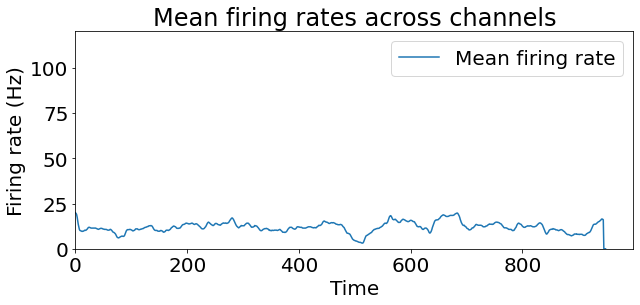

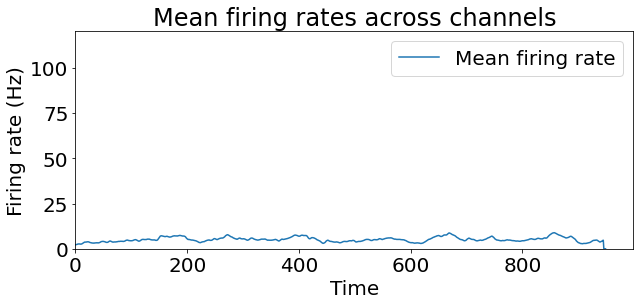

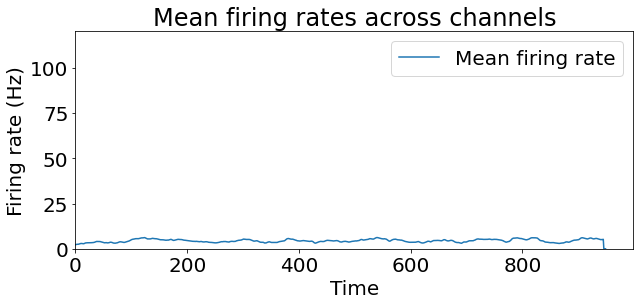

start feedforward
0.02


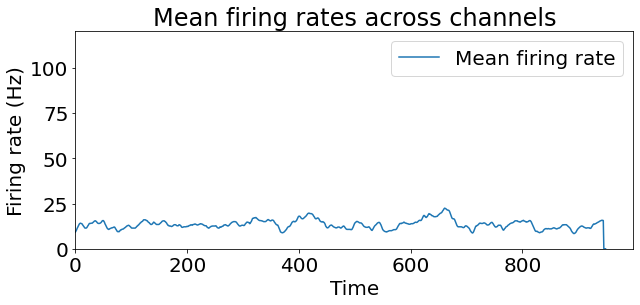

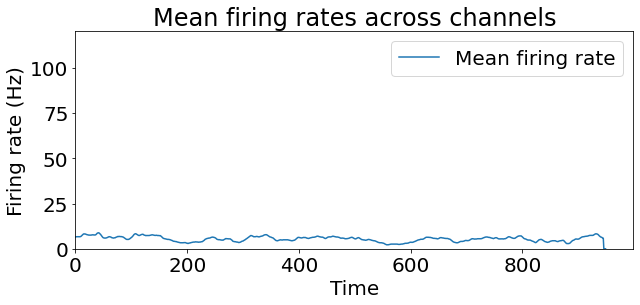

start feedforward
0.04


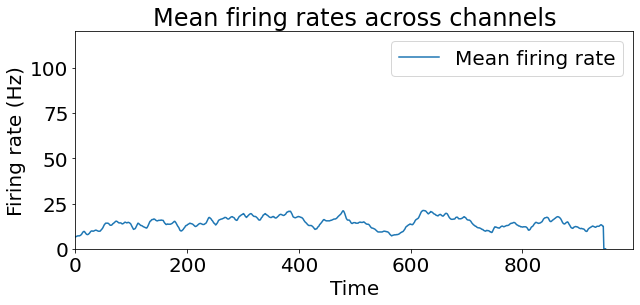

start feedforward
0.06


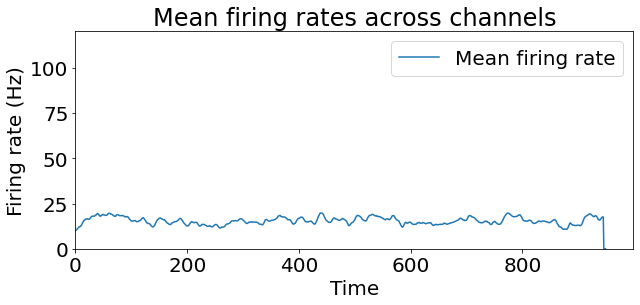

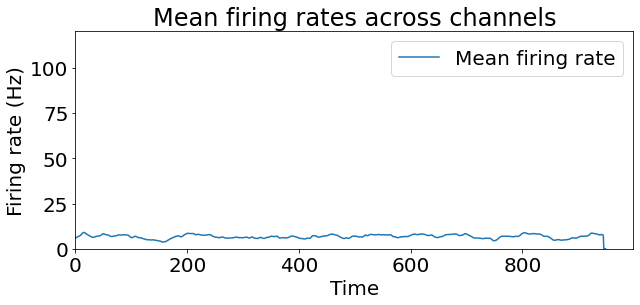

start feedforward
0.08


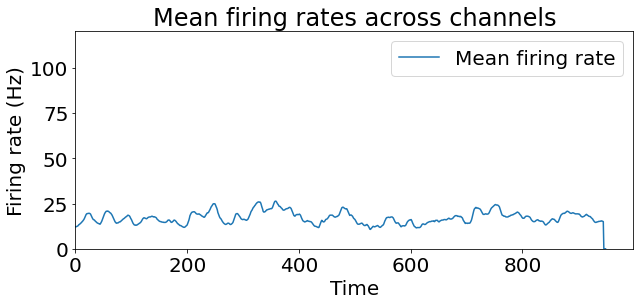

start feedforward
0.1


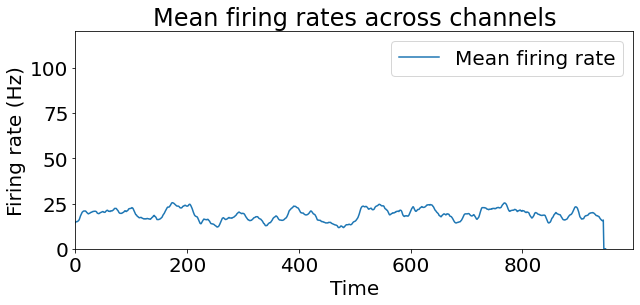

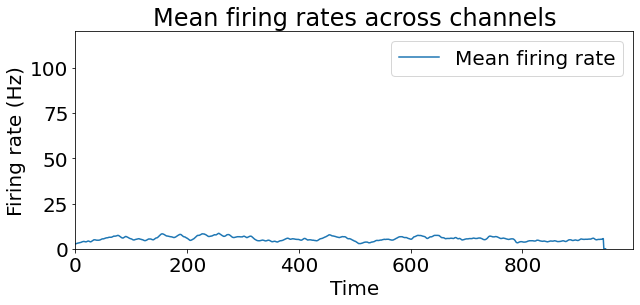

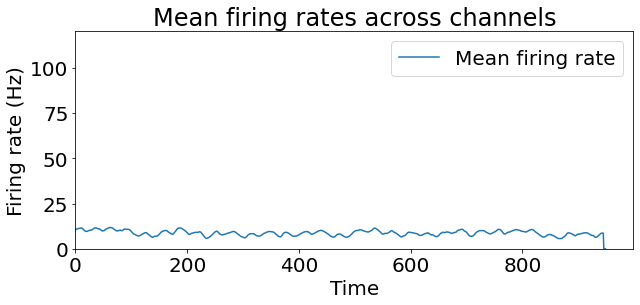

start feedforward
0.12


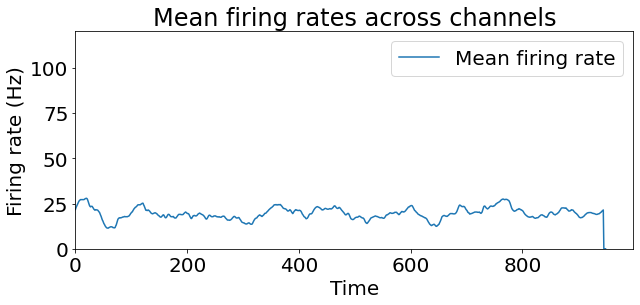

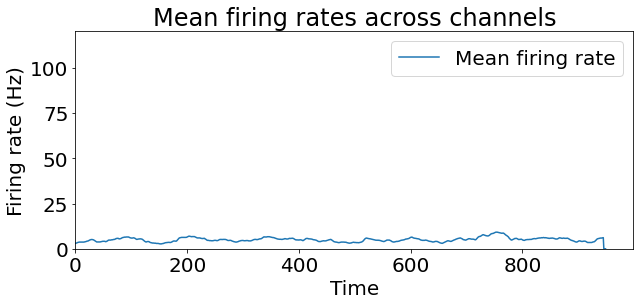

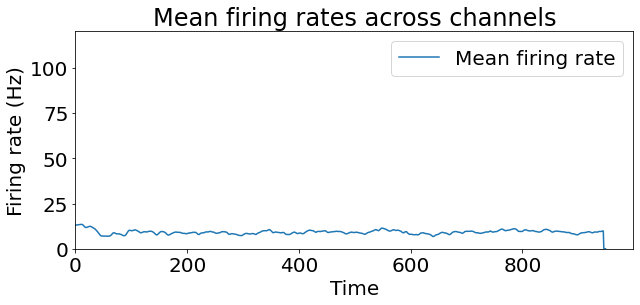

start feedforward
0.14


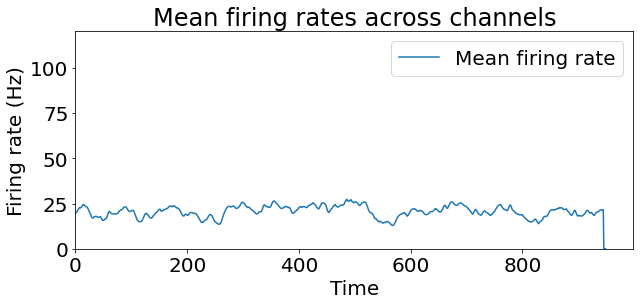

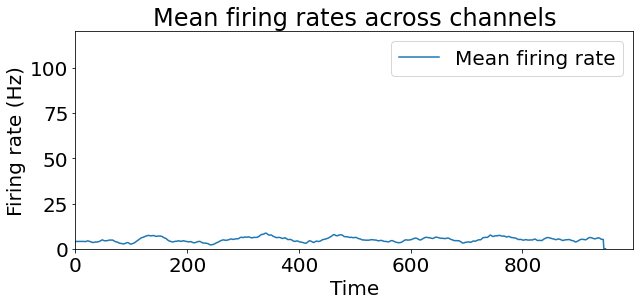

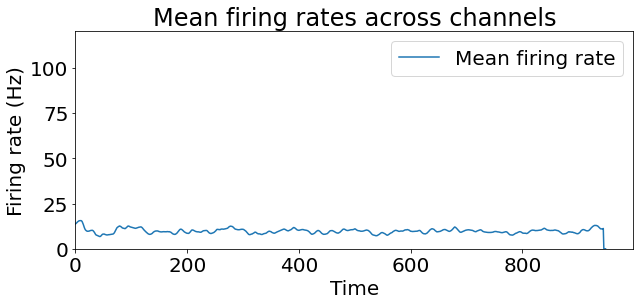

start feedforward
0.16


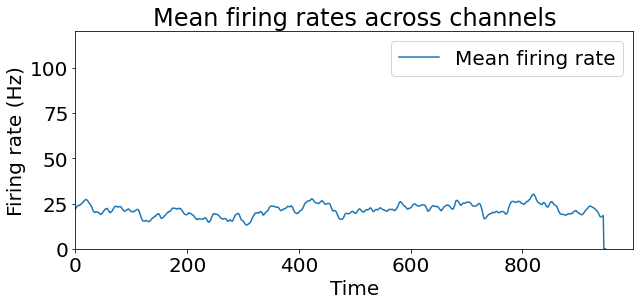

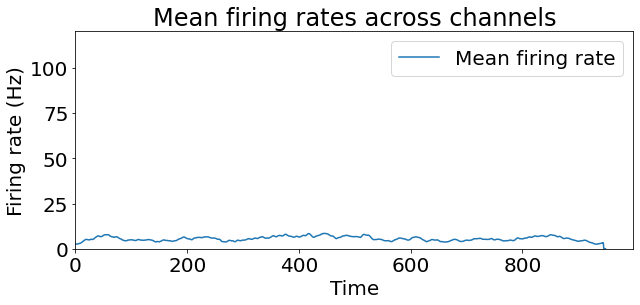

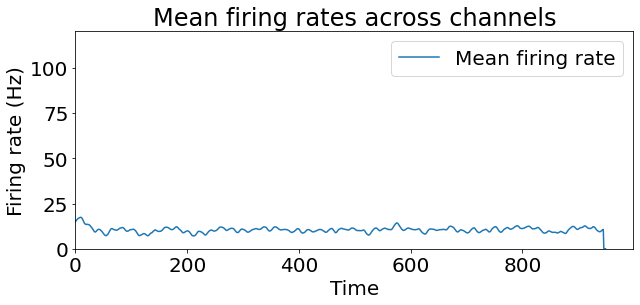

start feedforward
0.18


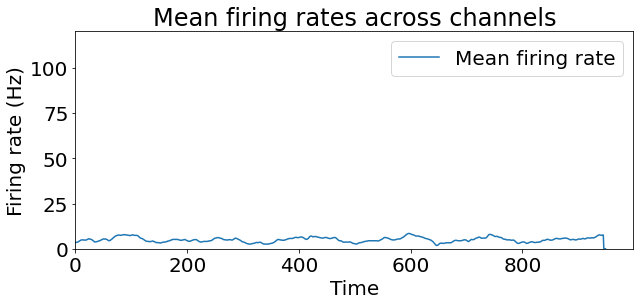

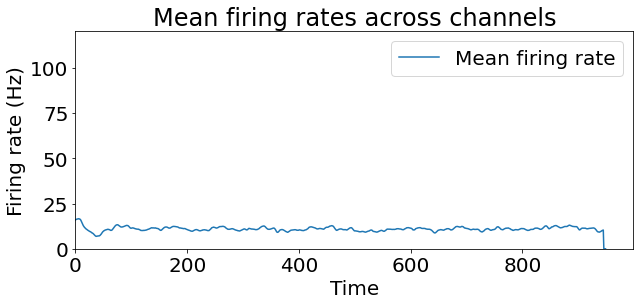

start feedforward
0.2


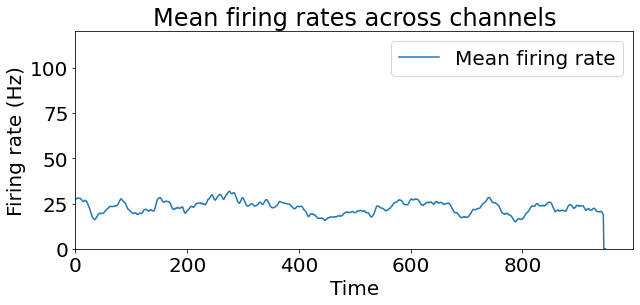

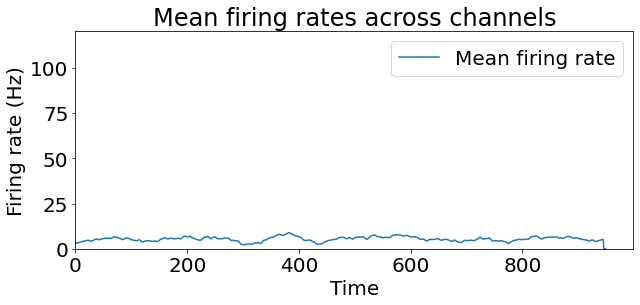

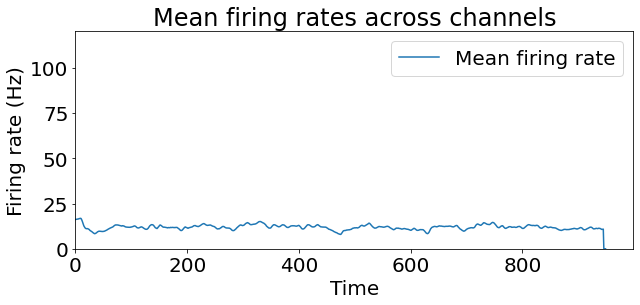

start feedforward
0.22


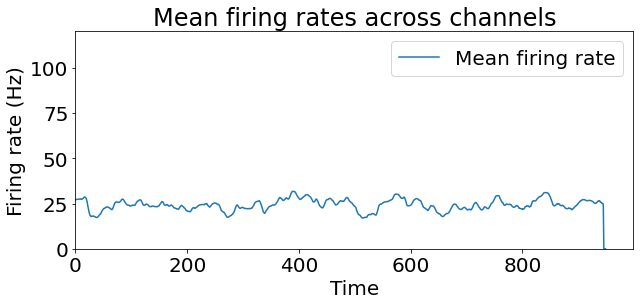

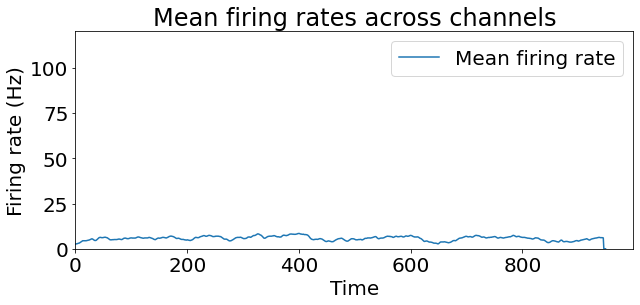

start feedforward
0.24


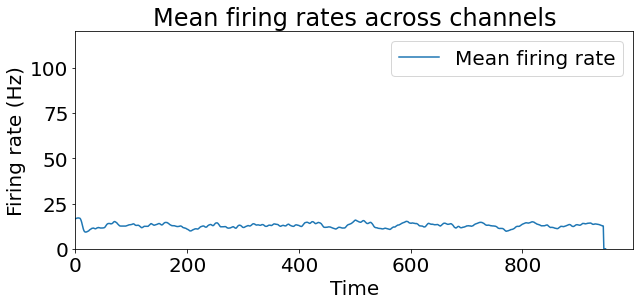

start feedforward
0.26


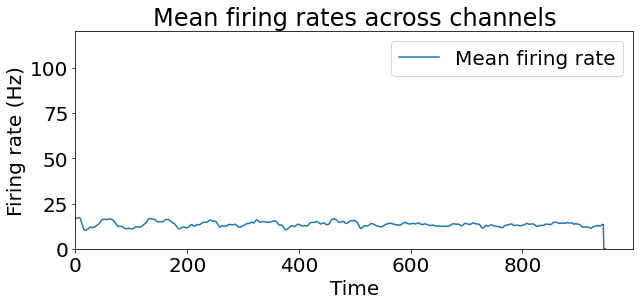

start feedforward
0.28


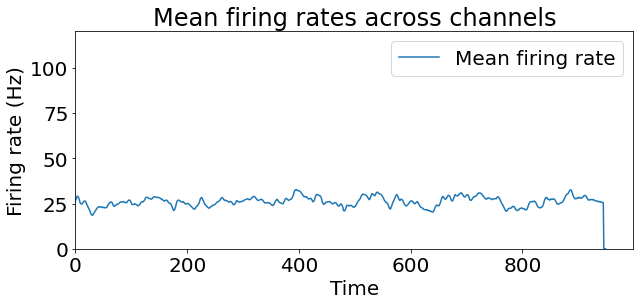

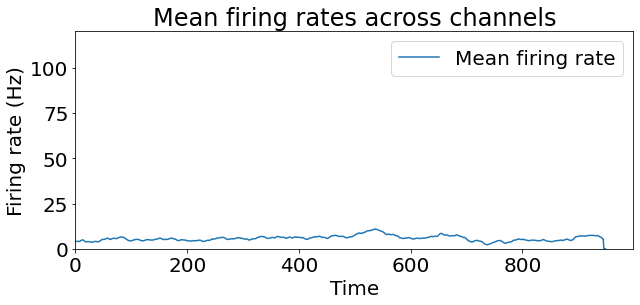

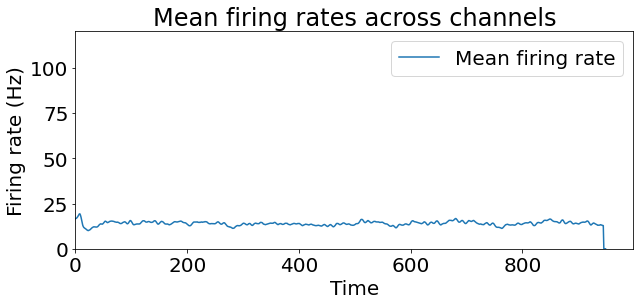

start feedforward
0.3


start feedforward
0.32


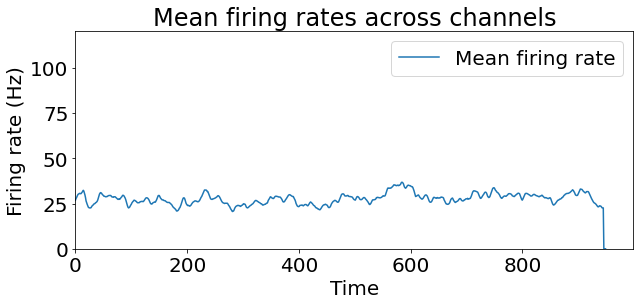

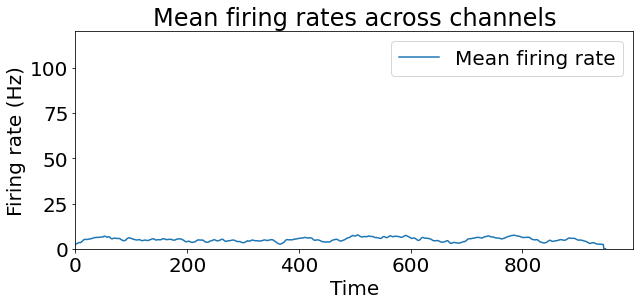

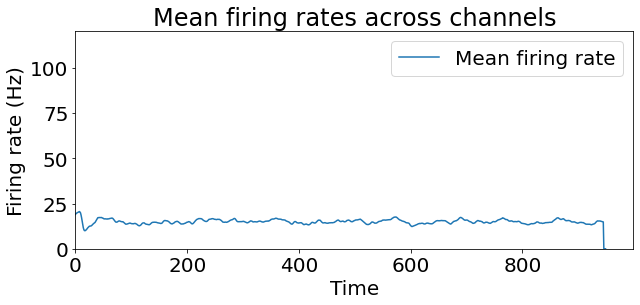

start feedforward
0.34


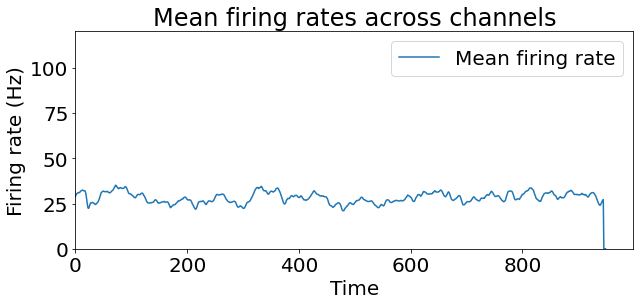

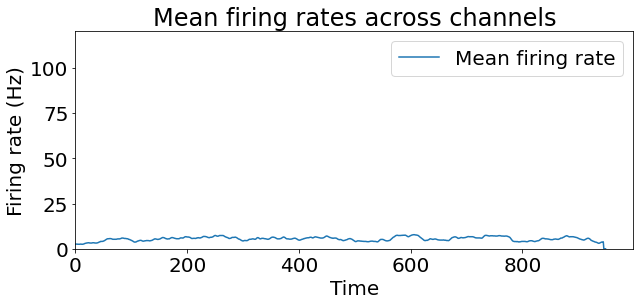

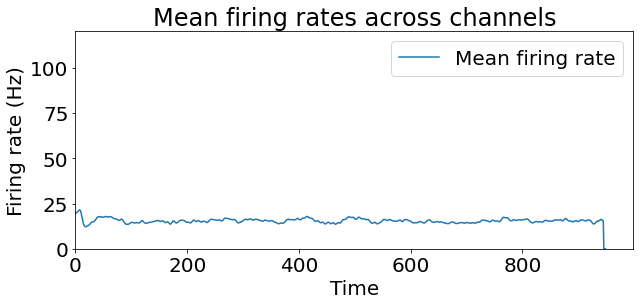

start feedforward
0.36


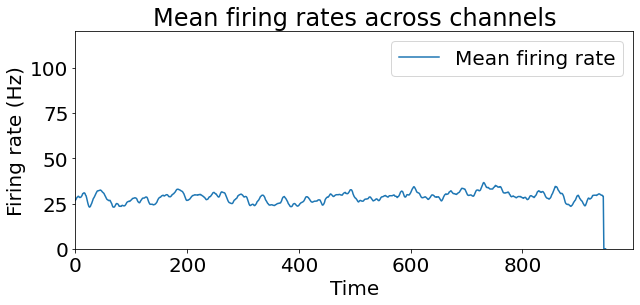

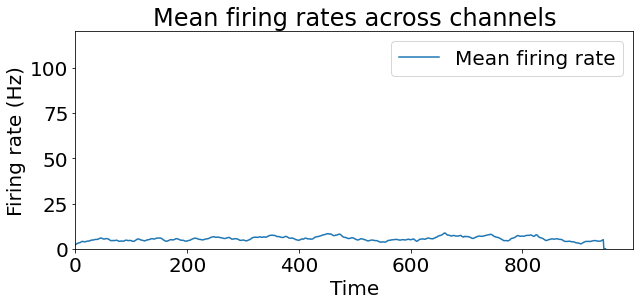

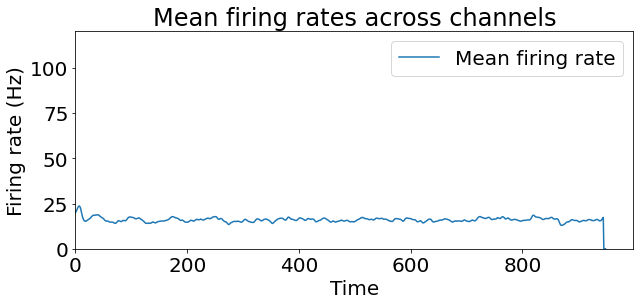

start feedforward
0.38


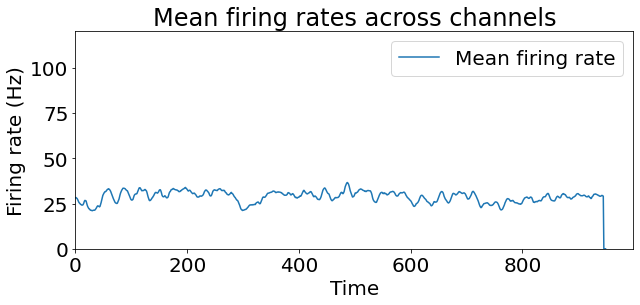

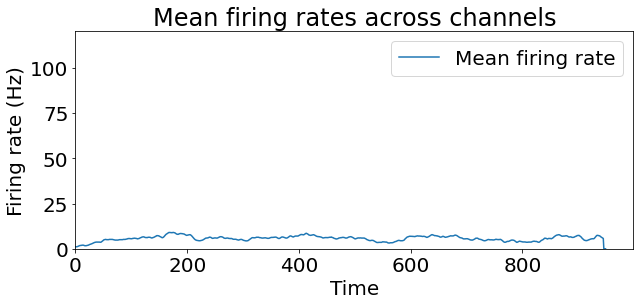

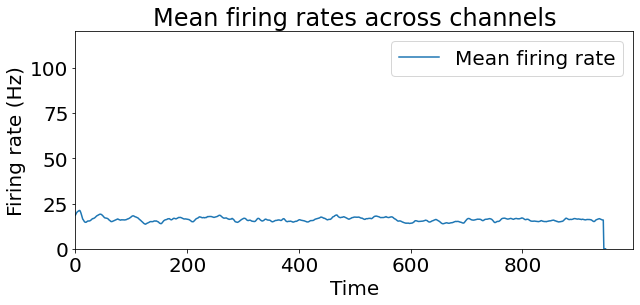

start feedforward
0.4


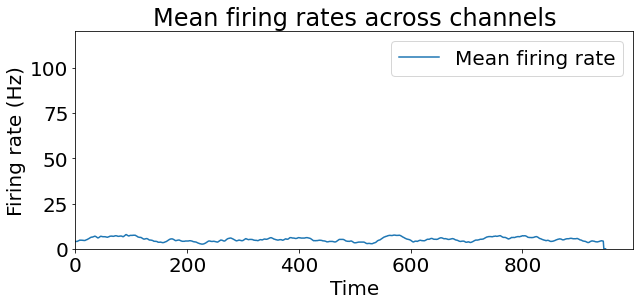

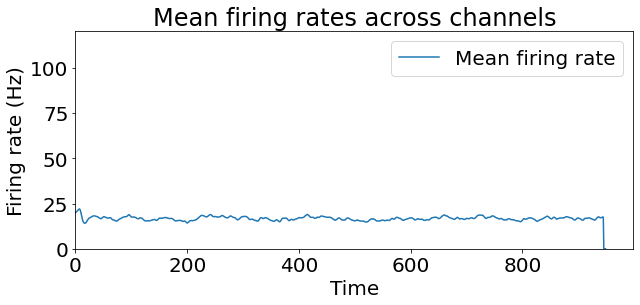

start feedforward
0.42


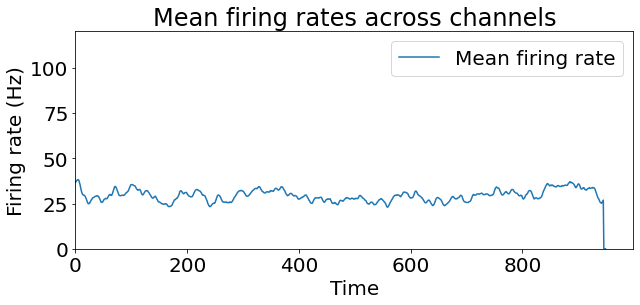

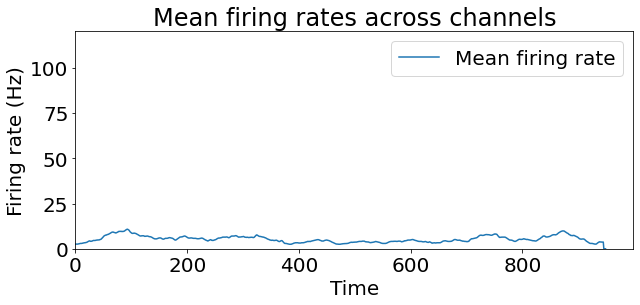

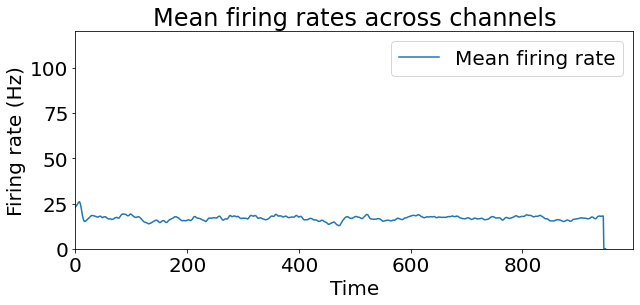

start feedforward
0.44


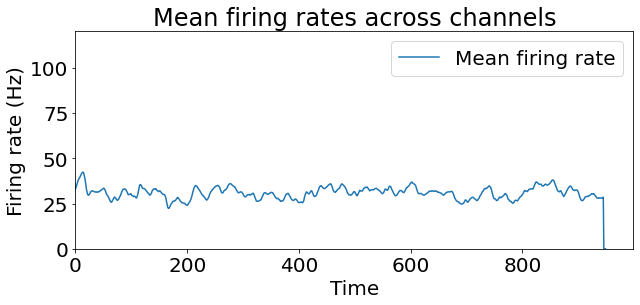

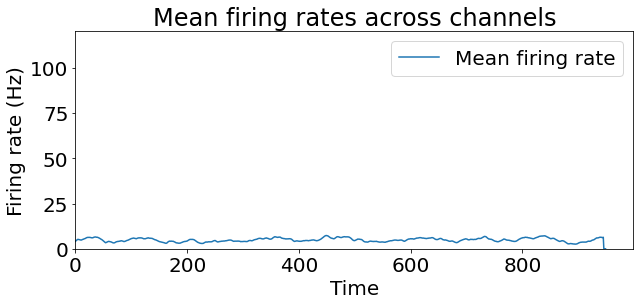

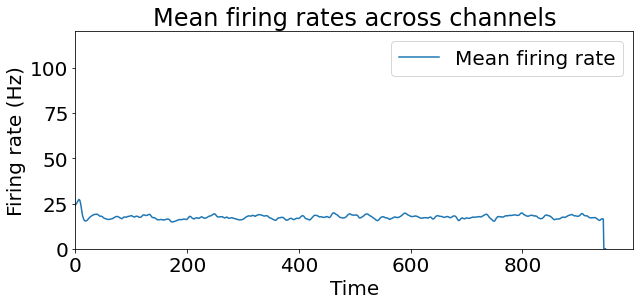

start feedforward
0.46


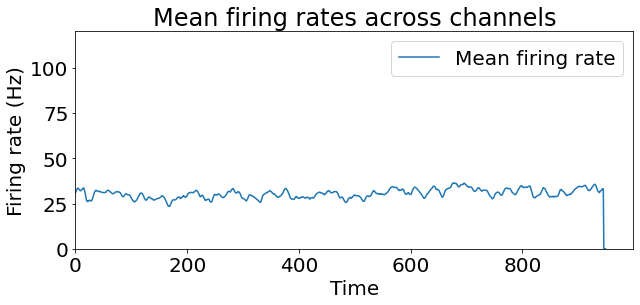

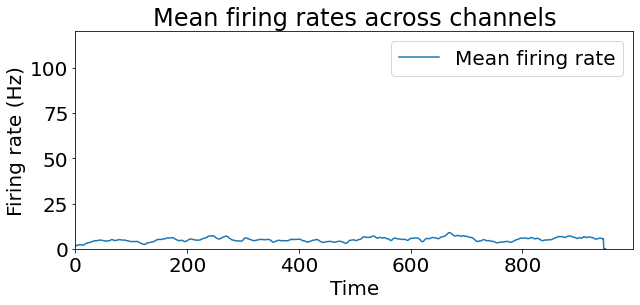

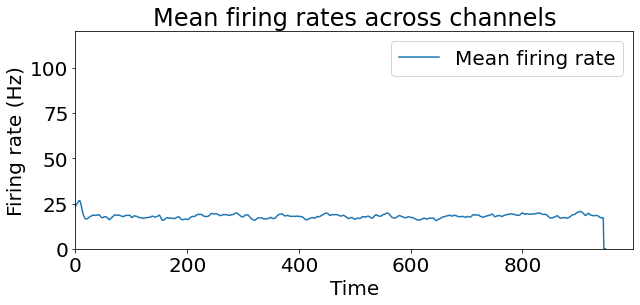

start feedforward
0.48


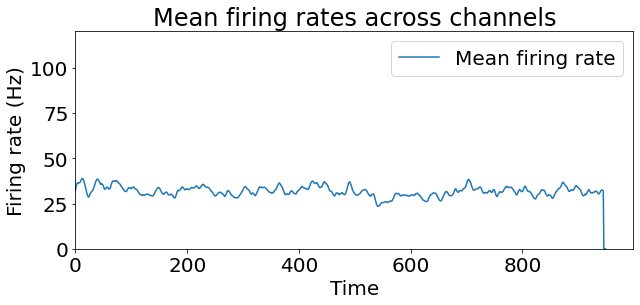

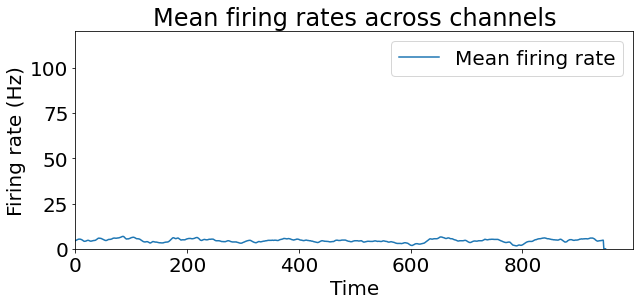

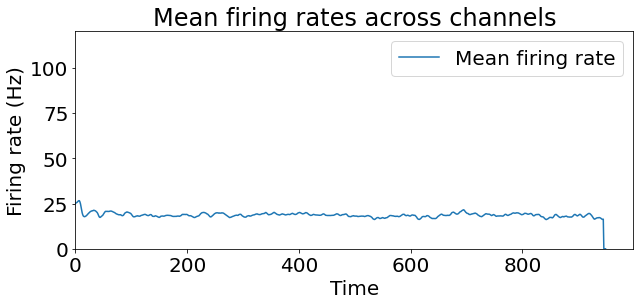

start feedforward
0.5


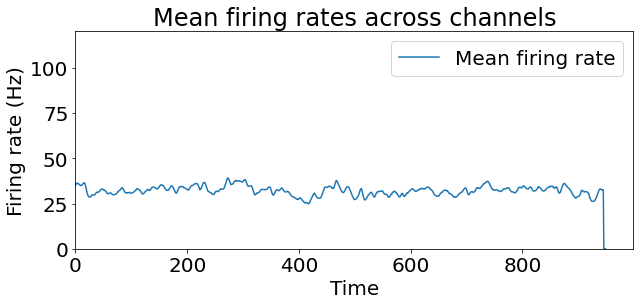

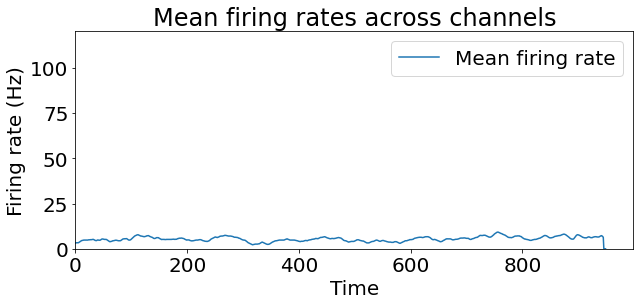

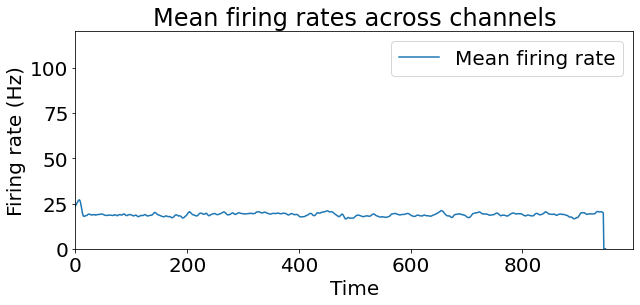

start feedforward
0.52


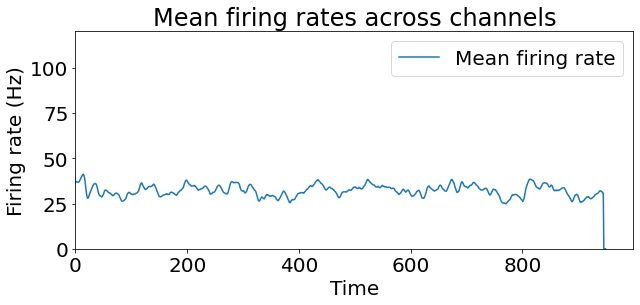

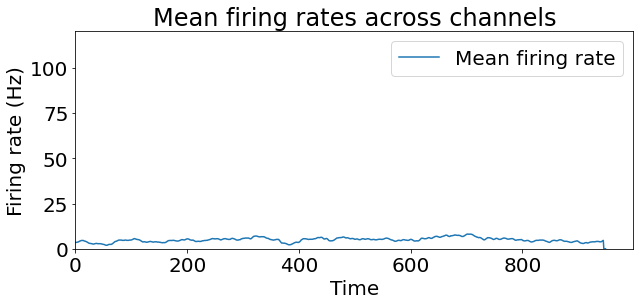

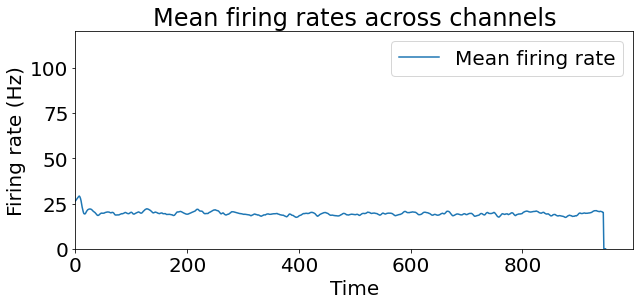

start feedforward
0.54


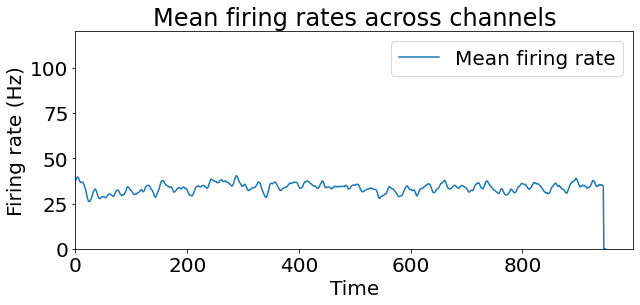

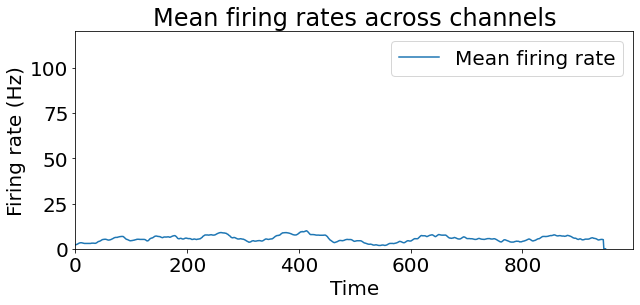

start feedforward
0.56


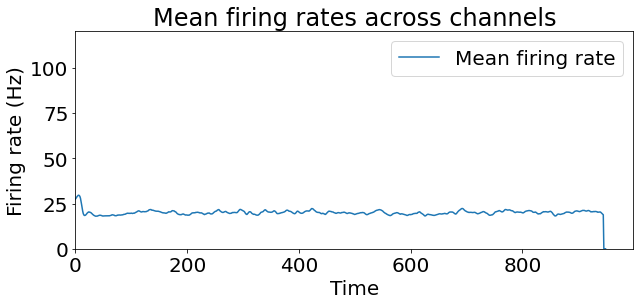

start feedforward
0.58


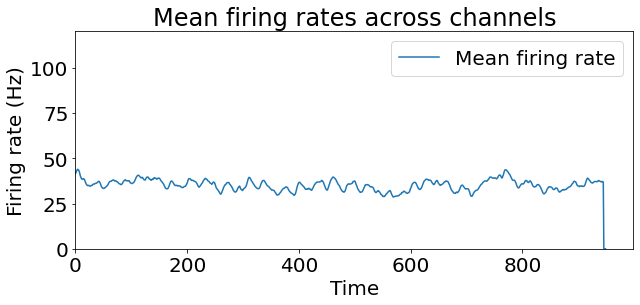

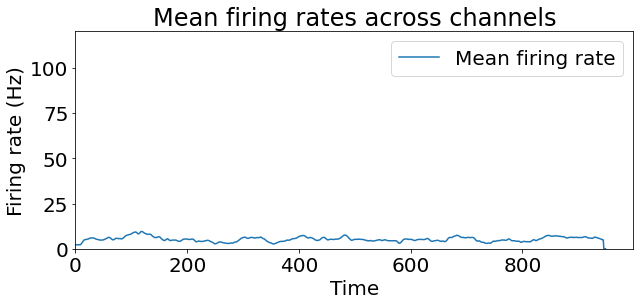

start feedforward
0.6


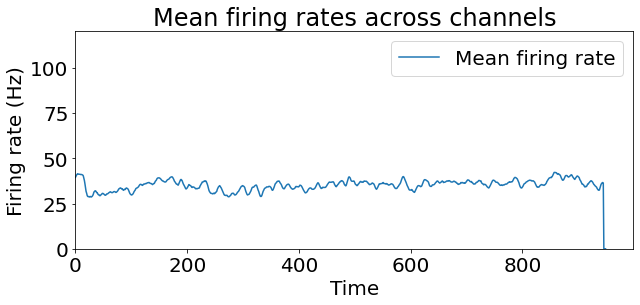

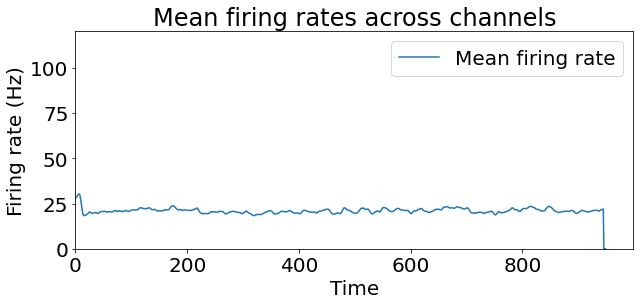

start feedforward
0.62


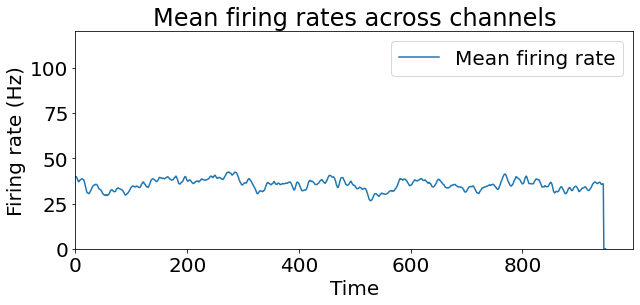

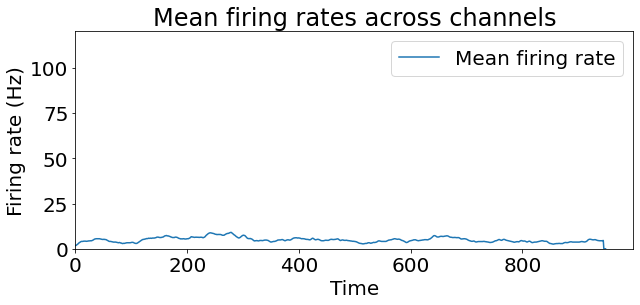

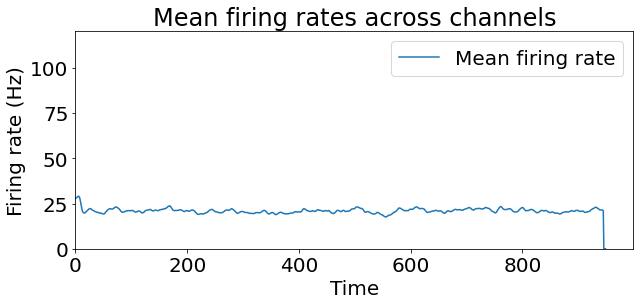

start feedforward
0.64


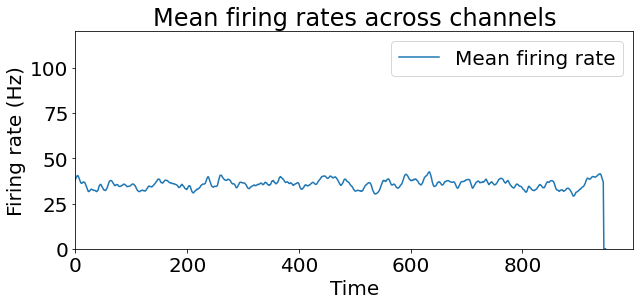

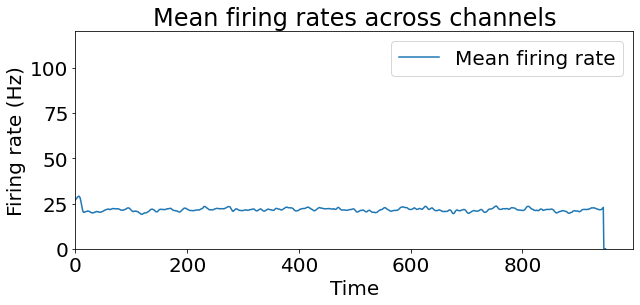

start feedforward
0.66


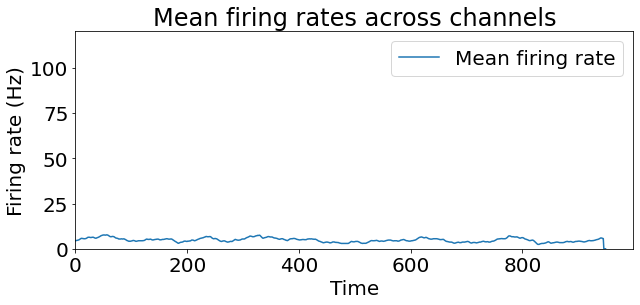

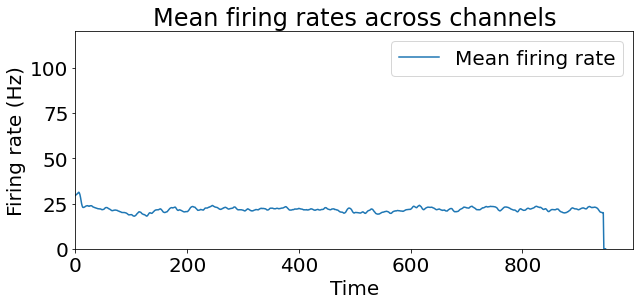

start feedforward
0.68


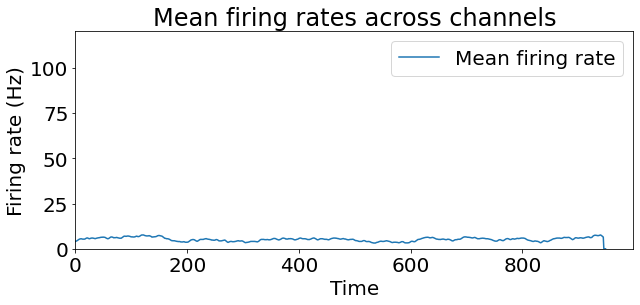

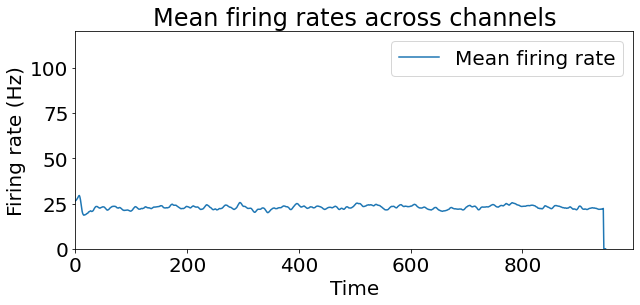

start feedforward
0.7000000000000001


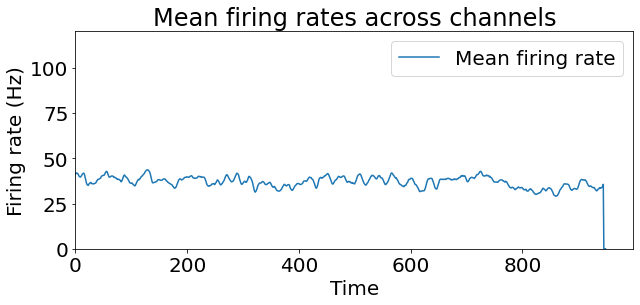

start feedforward
0.72


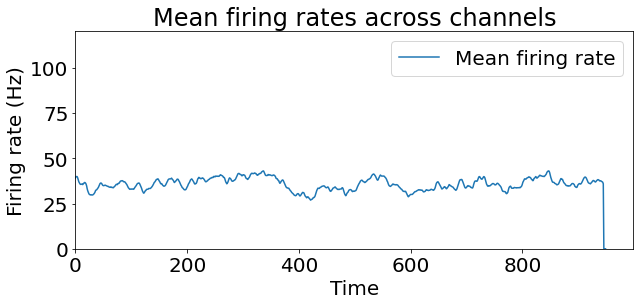

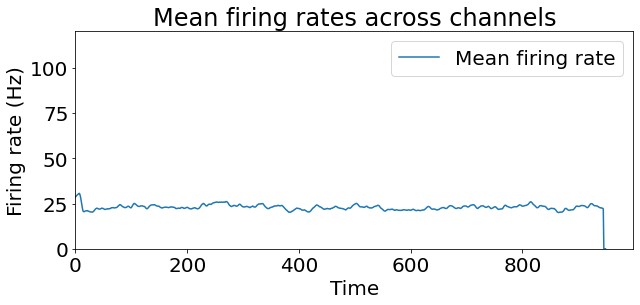

start feedforward
0.74


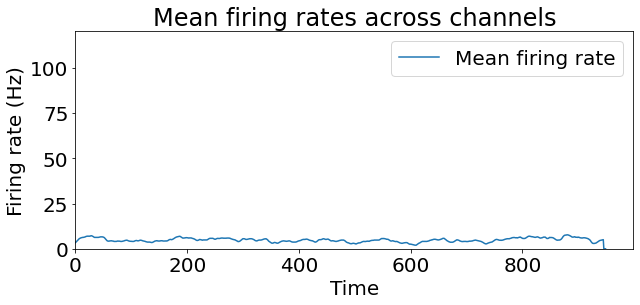

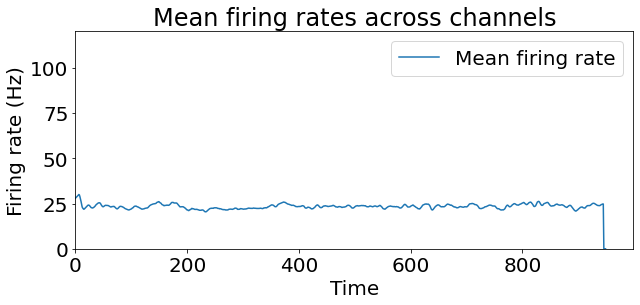

start feedforward
0.76


start feedforward
0.78


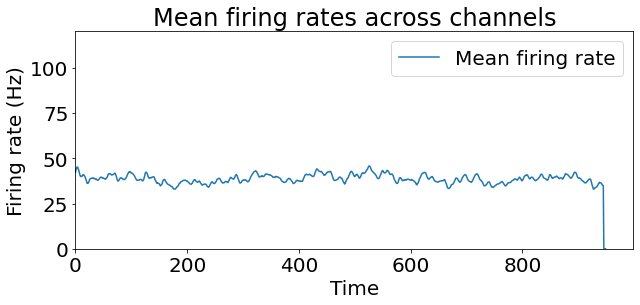

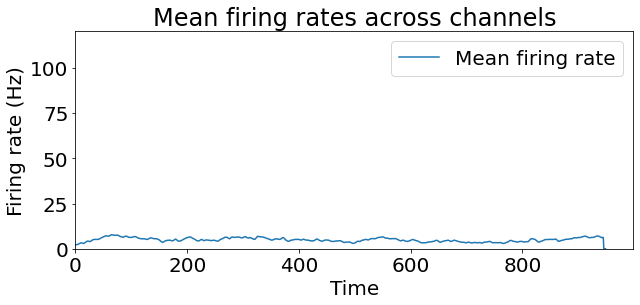

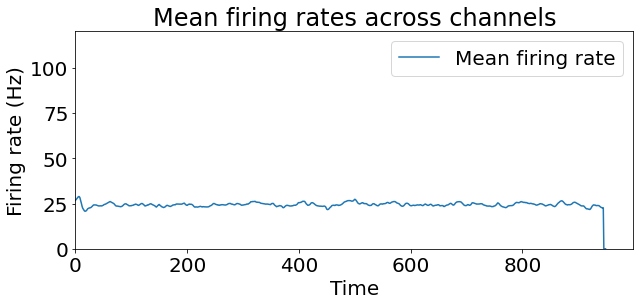

start feedforward
0.8


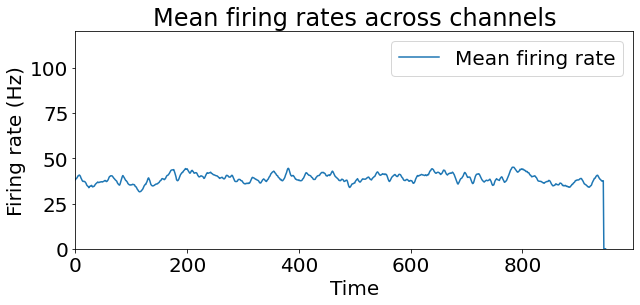

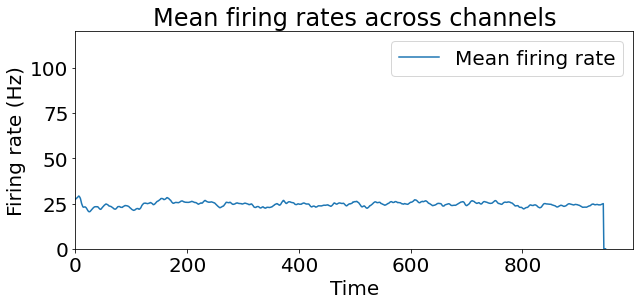

start feedforward
0.8200000000000001


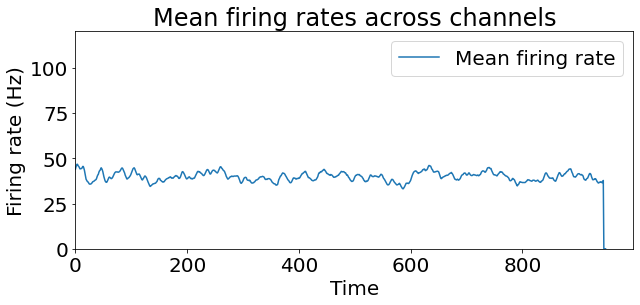

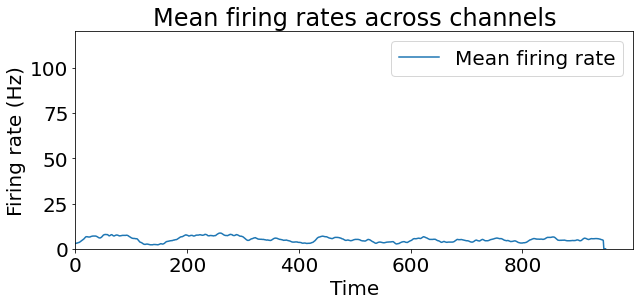

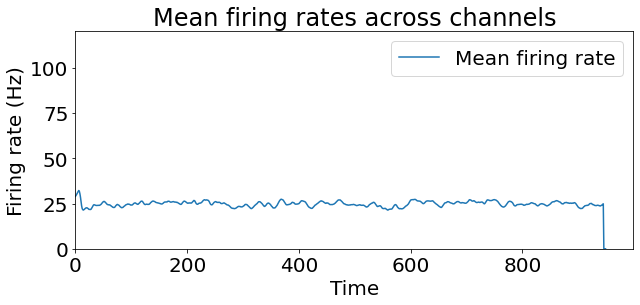

start feedforward
0.84


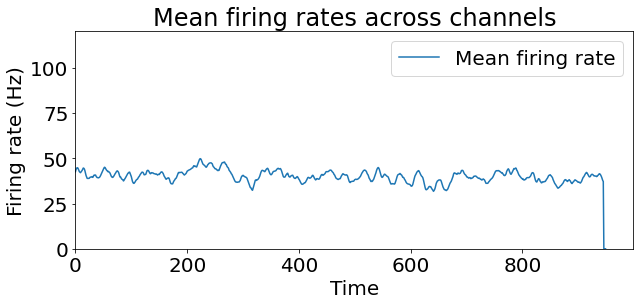

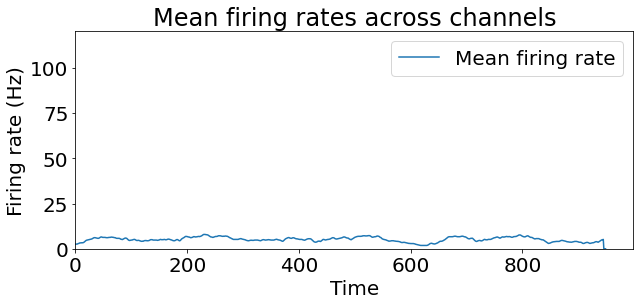

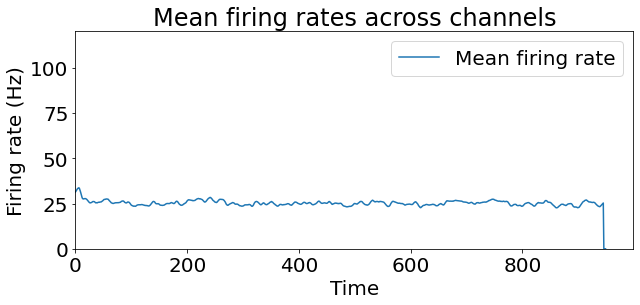

start feedforward
0.86


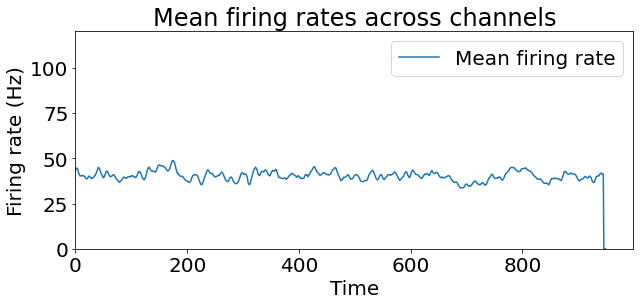

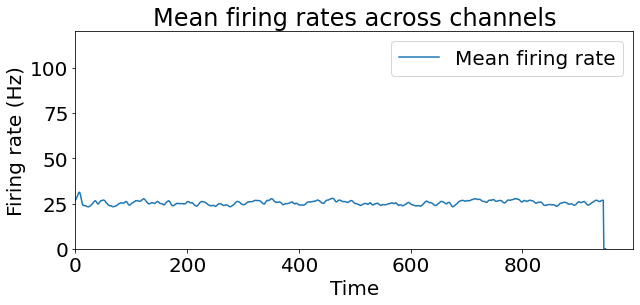

start feedforward
0.88


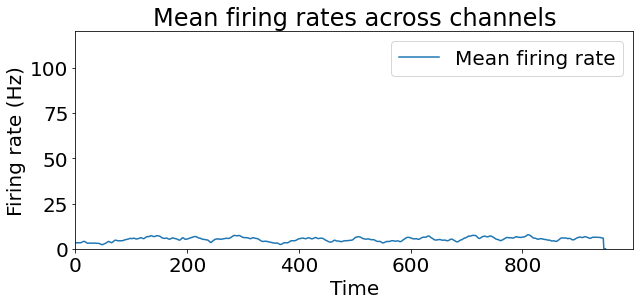

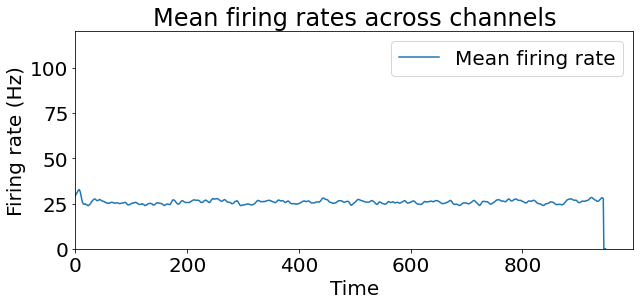

start feedforward
0.9


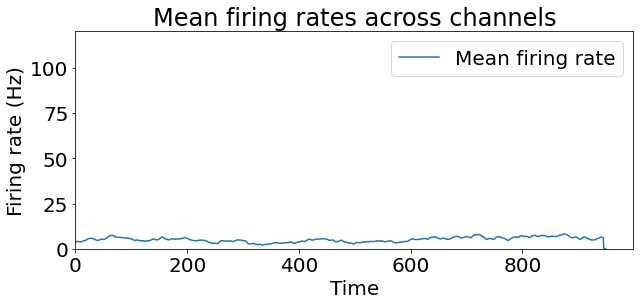

start feedforward
0.92


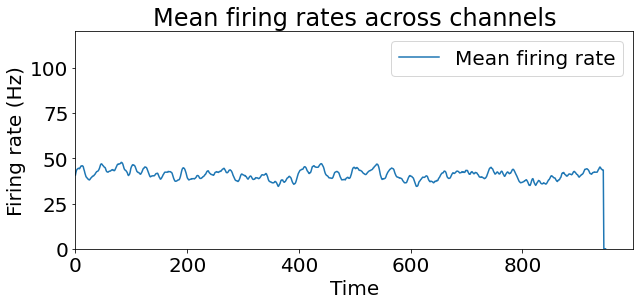

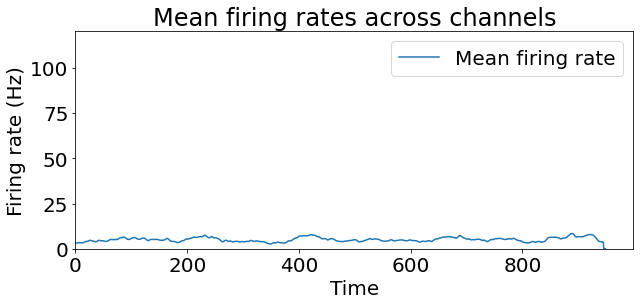

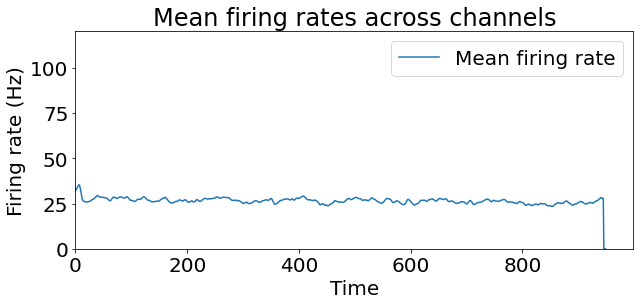

start feedforward
0.9400000000000001


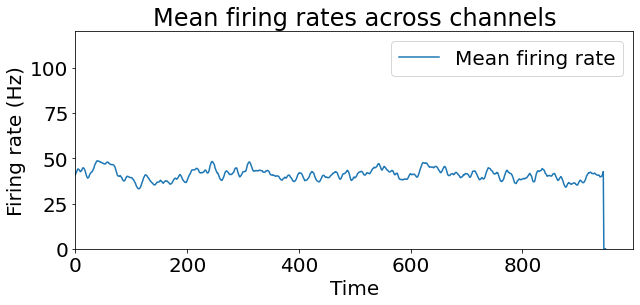

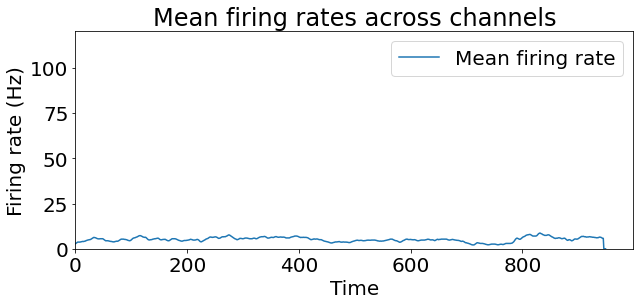

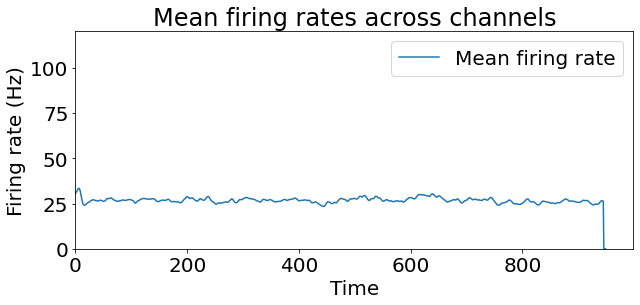

start feedforward
0.96


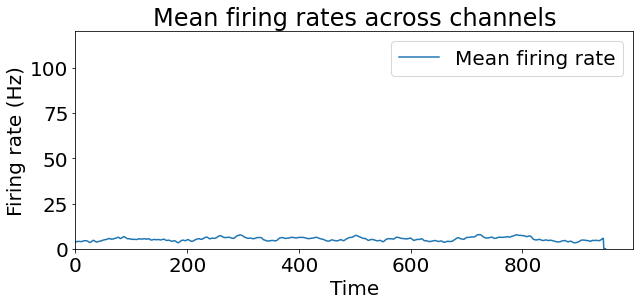

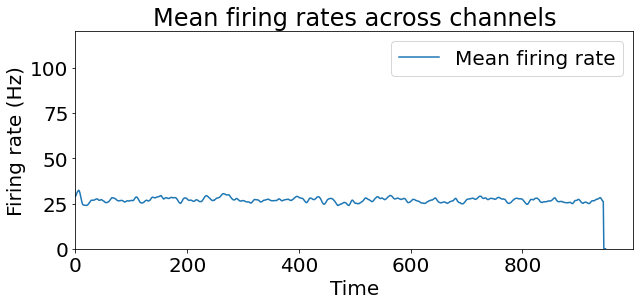

start feedforward
0.98


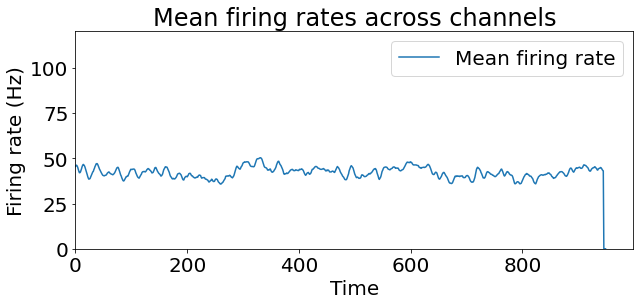

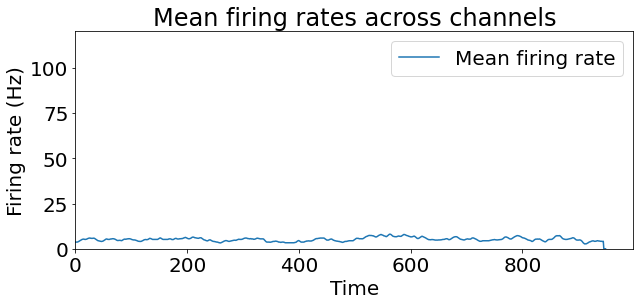

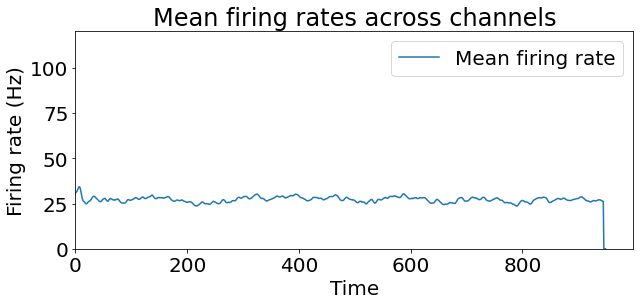

start feedforward
1.0


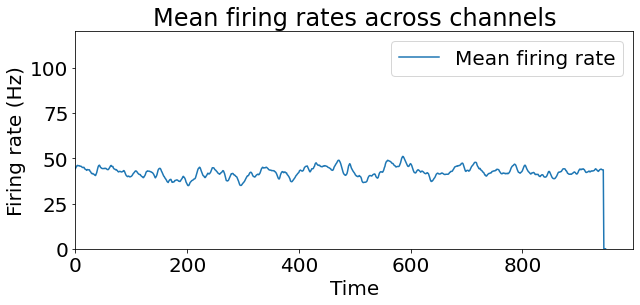

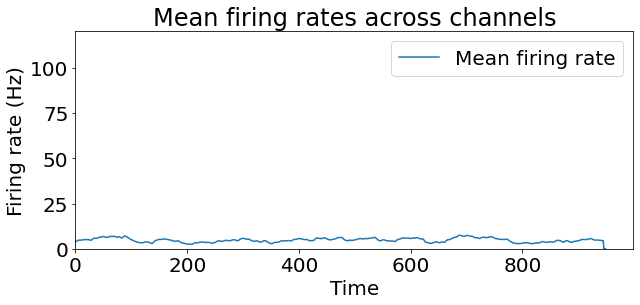

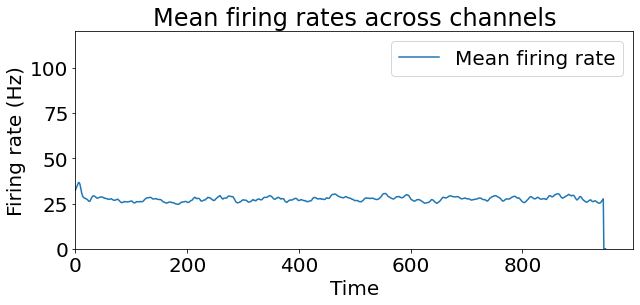

In [50]:
F_list = np.linspace(0, 1, 51)

num_stim = 1000

peak_firing_rates = []
mean_firing_rates = []
mean_firing_rates_SA = []
mean_firing_rates_RA = []

for F in F_list:
    
    stimulation = torch.zeros((pixel_h, pixel_w, num_stim), device=device)

    max_F = 0.02
    frequency = F
    F_array = np.full((1000,), max_F)
    
    for i, F_i in enumerate(F_array):
        stim_dot = full_stim(F=max_F, pixel_h=pixel_h, pixel_w=pixel_w)
        
        # Apply sinwave form with the given frequency
        intensity = np.sin(frequency * i)
        stimulation[:, :, i] = stim_dot * intensity


    S = SNNModel([SA_layers, RA_layers, CN_layers], [SA_synapses, RA_synapses, CN_synapses], rf_sizes=rf_sizes, device = device)

    S.feedforward(stimulation)
    print(F)

    mean_firing_rate = plot_mean_firing_rates(S.CN_spike_times[1], size= (10,4))
    mean_firing_rate_SA = plot_mean_firing_rates(S.SA_spike_times[2], size= (10,4))
    mean_firing_rate_RA = plot_mean_firing_rates(S.RA_spike_times[2], size= (10,4))

    peak_firing_rates.append(np.max(mean_firing_rate.numpy()))
    mean_firing_rates.append(np.mean(mean_firing_rate.numpy()))

    mean_firing_rates_SA.append(np.mean(mean_firing_rate_SA.numpy()))
    mean_firing_rates_RA.append(np.mean(mean_firing_rate_RA.numpy()))

plt.figure(figsize=(10, 5))
plt.scatter(F_list, mean_firing_rates_RA, label="Peak Firing Rate (RA)", marker='o')
plt.scatter(F_list, mean_firing_rates_SA, label="Peak Firing Rate (SA)", marker='o')
plt.scatter(F_list, mean_firing_rates, label="Mean Firing Rate", marker='o')

plt.xlabel("Stimulus Intensity")
plt.ylabel("Firing Rate (Hz)")
plt.legend()
plt.show()

In [51]:
plt.figure(figsize=(6, 5))
plt.scatter(F_list, mean_firing_rates, label="(CN)", marker='o')
plt.scatter(F_list, mean_firing_rates_RA, label="(RA)", marker='o')
plt.scatter(F_list, mean_firing_rates_SA, label="(SA)", marker='o')


plt.xlabel("Stimulus Intensity")
plt.ylabel("Firing Rate (Hz)")
plt.legend()
plt.show()